<a href="https://colab.research.google.com/github/Maxvgrad/Binary-Classification-with-a-Software-Defects-Dataset/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Binary Classification with a Software Defects Dataset

# Code

## Download dataset - Kaggle

In [ ]:
from google.colab import files

files.upload(); # upload your kaggle.json file

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [ ]:
dataset_name = 'playground-series-s3e23'
previous_dataset_path = '/content/{/content}/competitions/' + dataset_name
dataset_path = previous_dataset_path.replace('/{/content}', '')
dataset_archive = dataset_name + '.zip'

In [ ]:
!kaggle competitions download -c {dataset_name}

In [ ]:
!mkdir -p competitions/playground-series-s3e23
!mv {previous_dataset_path}/{dataset_archive} {dataset_path}/{dataset_archive}
!unzip {dataset_path}/{dataset_archive} -d {dataset_path}

# Optional clean up
!rm -r '{'
!rm {dataset_path}/{dataset_archive}

In [ ]:
!kaggle competitions submit -c {dataset_name} -f {dataset_path}/sample_submission.csv -m "Sample submission test"

## Download dataset - filesystem

In [3]:
from google.colab import files

files.upload(); # train.csv

Saving train.csv to train.csv


## Base line submission

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier

from imblearn.over_sampling import SMOTE

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [5]:
# Download the dataset
!mv 'train.csv' 'defects.csv' # In case the file is named train.csv in local filesystem, then rename
df = pd.read_csv('defects.csv')

In [6]:
# The dataset contains data about 101763 code modules and it has 23 columns.
df.shape

(101763, 23)

In [7]:
df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [8]:
#Remove the "id" column as we don't need it as a feature
df = df.drop('id', axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

In [10]:
## Check for missing values:
df.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [11]:
#Check for duplicates
duplicate_rows = df[df.duplicated()]
duplicate_rows

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects


In [12]:
#Convert target column values from boolean to numerical - True -> 1 (yes defect), False -> 0 (no defect)
df['defects'] = df['defects'].astype(int)

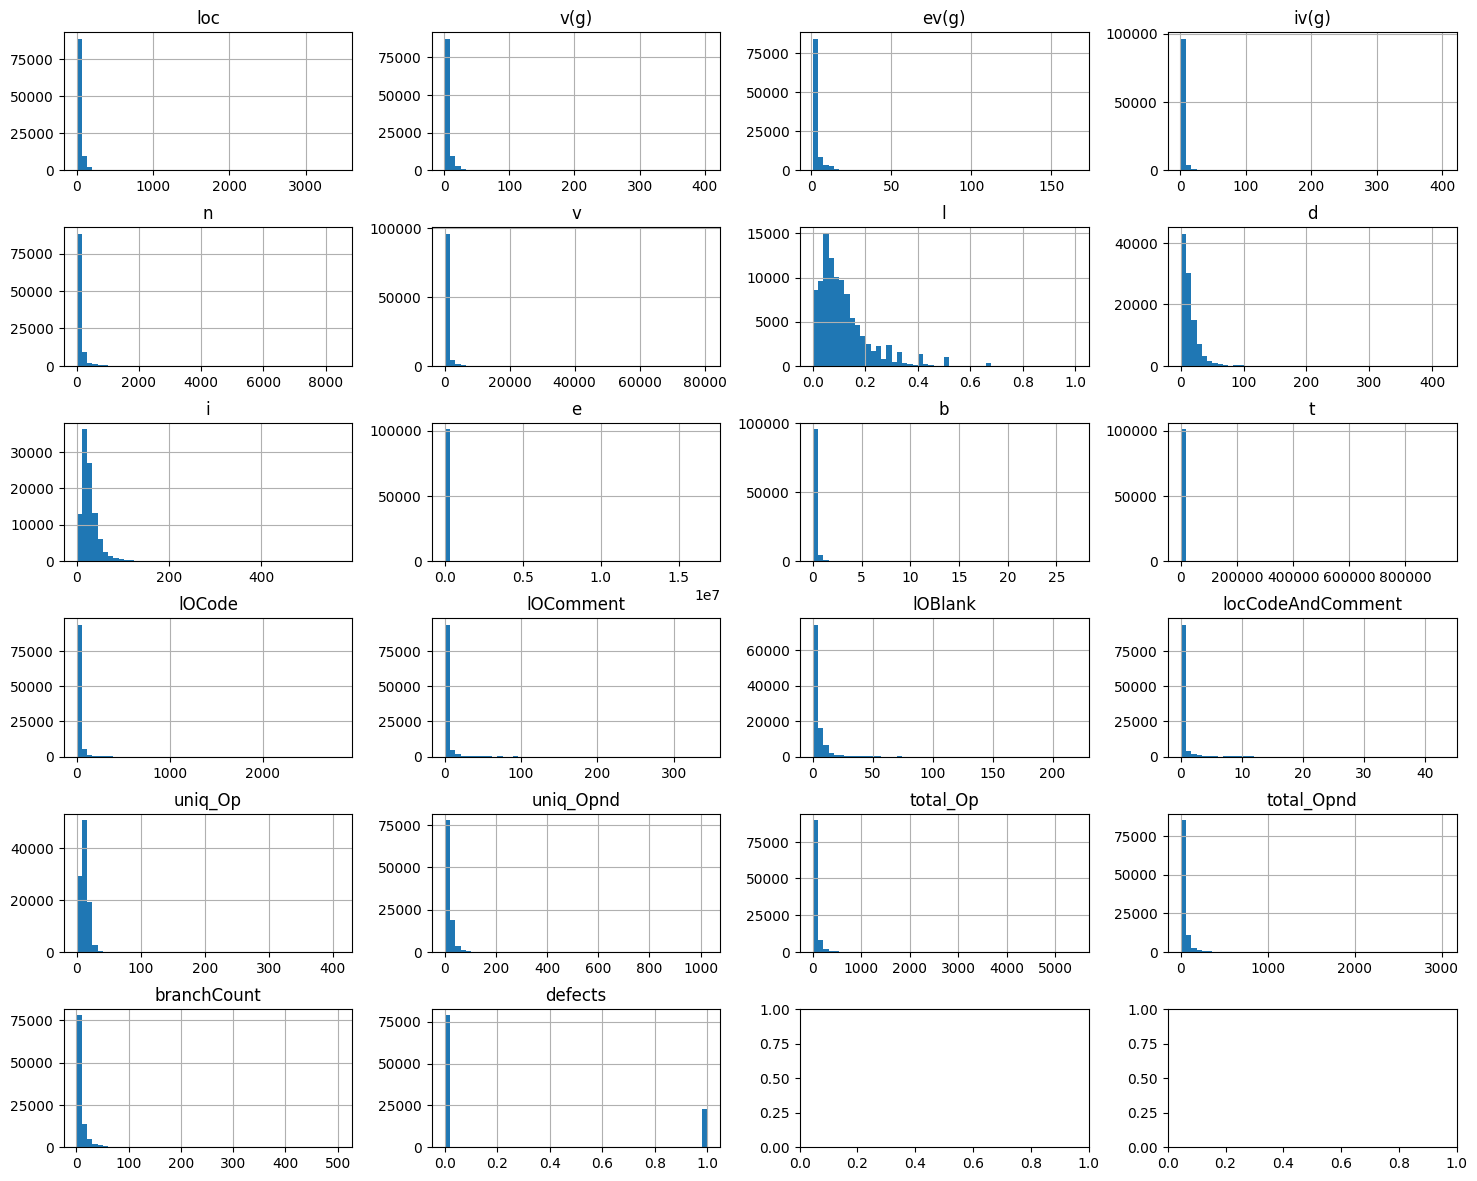

In [13]:
# Distribution plots for features
rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
fig.tight_layout(pad=2.0)
axe = axes.ravel()

for i, feature in enumerate(df.columns):
    axe[i].set_title(feature)
    df[feature].hist(bins=50, ax=axe[i])

plt.show()

In [14]:
#Checking for class imbalance
class_counts = df['defects'].value_counts()
class_proportions = df['defects'].value_counts(normalize=True)
print("Class 0 count:", class_counts[0])
print("Class 1 count:", class_counts[1])

print("Class 0 proportion:", class_proportions[0])
print("Class 1 proportion:", class_proportions[1])



Class 0 count: 78699
Class 1 count: 23064
Class 0 proportion: 0.7733557383331859
Class 1 proportion: 0.22664426166681406


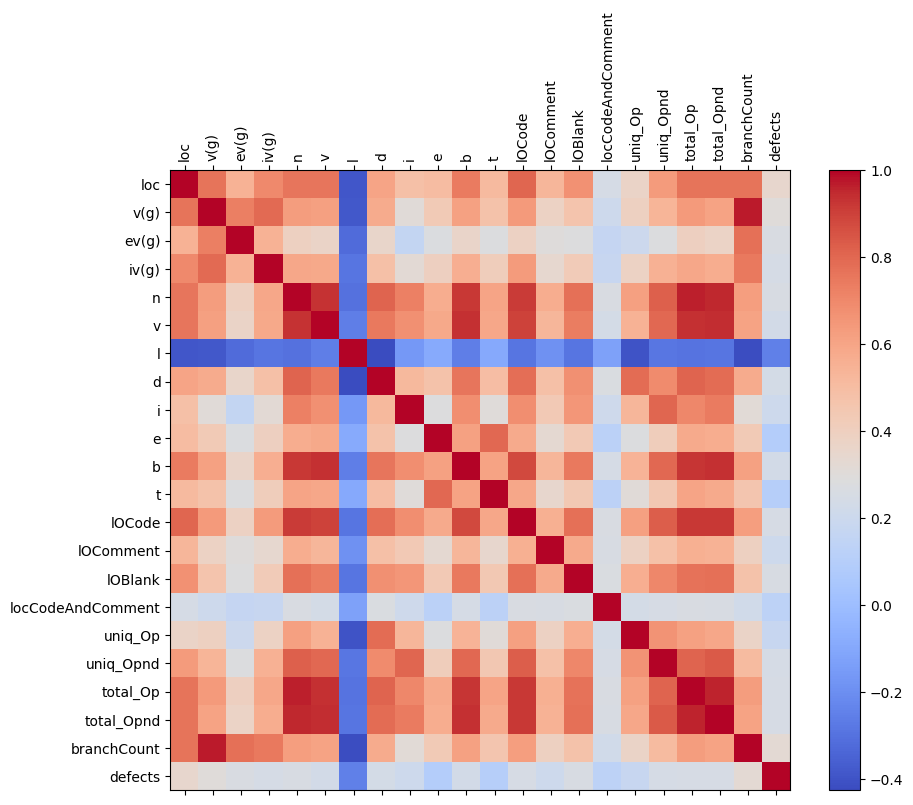

In [15]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

## Data Preprocessing

In [16]:
#Based on the maximum values of the columns in the dataset, we can conclude that the range of values for different features varies significantly.
#We need to scale the data.
df.max()

loc                      3442.00
v(g)                      404.00
ev(g)                     165.00
iv(g)                     402.00
n                        8441.00
v                       80843.08
l                           1.00
d                         418.20
i                         569.78
e                    16846621.12
b                          26.95
t                      935923.39
lOCode                   2824.00
lOComment                 344.00
lOBlank                   219.00
locCodeAndComment          43.00
uniq_Op                   410.00
uniq_Opnd                1026.00
total_Op                 5420.00
total_Opnd               3021.00
branchCount               503.00
defects                     1.00
dtype: float64

## Model training

In [17]:
SEED=123

In [18]:
from sklearn.model_selection import train_test_split

target_column = 'defects'

X = df.drop(target_column, axis=1)
y = df[target_column]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # make sure to use stratify, dataset is inbalanced

### Baseline

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score # read: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

baseline_model = DummyClassifier(strategy='stratified', random_state=42)

baseline_model.fit(X, y)

y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

acc_baseline = accuracy_score(y_test, y_pred)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba)

print(f'Baseline - Accuracy score: {acc_baseline:.4f}')
print(f'Baseline - ROC AUC: {roc_auc_baseline:.4f}')

Baseline - Accuracy score: 0.6470
Baseline - ROC AUC: 0.4959


### Naive solution (LogisticRegression)

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

skf = StratifiedKFold(n_splits=5)
model = LogisticRegression(max_iter=1000)
scores = np.array([])
roc_aucs = np.array([])

for train_index, val_index in skf.split(X, y):

  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  y_pred_proba = model.predict_proba(X_val)[:, 1]

  scores = np.append(scores, model.score(X_val, y_val))
  roc_aucs = np.append(roc_aucs, roc_auc_score(y_val, y_pred_proba))


print(f'LogisticRegression - Average accuracy score: {np.mean(scores):.4f}')
print(f'LogisticRegression - ROC AUC: {np.mean(roc_aucs):.4f}')


LogisticRegression - Average accuracy score: 0.7891
LogisticRegression - ROC AUC: 0.6717


In [21]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'LogisticRegression - Accuracy score: {acc:.4f}')
print(f'LogisticRegression - ROC AUC: {roc_auc:.4f}')

LogisticRegression - Accuracy score: 0.7883
LogisticRegression - ROC AUC: 0.6740


### Training 8 classifiers with default hyperparameters

*   Logistic Regression
*   Random Forest
*   Gradient Boosting
*   Decision Tree
*   Naive Bayes
*   K-Nearest Neighbors
*   XGBoost
*   AdaBoost

In [22]:
# Classifiers using default hyperparameters
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED),
}

In [23]:
# Data scalers

def get_scalers():
    scalers = {
        'minmax': [MinMaxScaler()],
        'standard': [StandardScaler()],
        'robust': [RobustScaler()],
        'noscaler': []
    }
    return scalers

oversampling_ratio = 0.5

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

k = 5
cv = StratifiedKFold(n_splits=k)

# Lists for storing training results
models_all = []
scaling_methods_all = []
cv_roc_aucs_all = []

scalers = get_scalers()

# Loop through scalers
for name_scaling, scaling_method in scalers.items():
    print()
    print('Scaling method: ', name_scaling)

    # Loop through classifiers
    for name, clf in classifiers.items():

        # Lists for results across CVs
        roc_aucs = []

        # Storing y_true and y_preds across all CV folds
        all_y_true = []
        all_y_preds = []


        classification_pipeline = make_pipeline(*scaling_method, clf)
        roc_aucs_scores = cross_val_score(classification_pipeline, X, y, cv=cv, scoring='roc_auc')
        cv_roc_auc = np.mean(roc_aucs_scores)

        print(f"Model: {name}, ROC AUC: {cv_roc_auc:.4f}")

        # Add results to the lists
        models_all.append(name)
        scaling_methods_all.append(name_scaling)
        cv_roc_aucs_all.append(cv_roc_auc)

print()
print('Done!')


Scaling method:  minmax
Model: Logistic Regression, ROC AUC: 0.7740
Model: Random Forest, ROC AUC: 0.7684
Model: Gradient Boosting, ROC AUC: 0.7899
Model: Decision Tree, ROC AUC: 0.6067
Model: Naive Bayes, ROC AUC: 0.7673
Model: K-Nearest Neighbors, ROC AUC: 0.7208
Model: XGBoost, ROC AUC: 0.7767
Model: AdaBoost, ROC AUC: 0.7877

Scaling method:  standard
Model: Logistic Regression, ROC AUC: 0.7789
Model: Random Forest, ROC AUC: 0.7685
Model: Gradient Boosting, ROC AUC: 0.7898
Model: Decision Tree, ROC AUC: 0.6073
Model: Naive Bayes, ROC AUC: 0.7673
Model: K-Nearest Neighbors, ROC AUC: 0.7200
Model: XGBoost, ROC AUC: 0.7767
Model: AdaBoost, ROC AUC: 0.7878

Scaling method:  robust
Model: Logistic Regression, ROC AUC: 0.7789
Model: Random Forest, ROC AUC: 0.7688
Model: Gradient Boosting, ROC AUC: 0.7898
Model: Decision Tree, ROC AUC: 0.6090
Model: Naive Bayes, ROC AUC: 0.7673
Model: K-Nearest Neighbors, ROC AUC: 0.7178
Model: XGBoost, ROC AUC: 0.7767
Model: AdaBoost, ROC AUC: 0.7878

S

In [31]:
results = pd.DataFrame()
results['scaling_method'] = scaling_methods_all
results['model'] = models_all
results['AUC'] = cv_roc_aucs_all

In [35]:
results.sort_values('AUC', ascending=False)[:10]

,scaling_method,model,AUC
2,minmax,Gradient Boosting,0.789922
10,standard,Gradient Boosting,0.789788
26,noscaler,Gradient Boosting,0.789763
18,robust,Gradient Boosting,0.789762
31,noscaler,AdaBoost,0.787842
23,robust,AdaBoost,0.787842
15,standard,AdaBoost,0.787842
7,minmax,AdaBoost,0.787732
8,standard,Logistic Regression,0.778918
16,robust,Logistic Regression,0.778891


In [ ]:
The best model with default hyperparameterss is Gradient Boost (oversampling ratio 0.5, standard scaler.

# Final Results

| # | Experiment         | Description                                         | ROC AUC | Accuracy |
|---|--------------------|-----------------------------------------------------|---------|----------|
| 1 | Baseline           | No dataset preprocessing                            | 0.5020  | 0.6514   |
| 2 | LogisticRegression | No dataset preprocessing, Cross validation 5 splits | 0.6524  | 0.7921   |
| 3 | Kaggle Top 1       |                                                     | 0.79136 | n/a      |




# Links

* Markdown table generator: https://www.tablesgenerator.com/markdown_tables
* ROC AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
